<a href="https://colab.research.google.com/github/aribamazharam/efficient-net/blob/main/Yoga_EfficientNet_b0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet_pytorch
!pip install torch torchvision

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=4522e755f4b9f6fcd1361790d39b2d81a80702deb58607d048d44db1c3e6999f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
from torchvision import datasets, transforms
import torch

# Path to your data
data_dir = '/content/drive/MyDrive/YogaPose/new_dataset'  # Replace with your dataset directory
train_dir = os.path.join(data_dir, 'train')  # Assuming you have a train directory
val_dir = os.path.join(data_dir, 'valid')  # Assuming you have a validation directory

# Define transformations for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_transforms)
test_data = datasets.ImageFolder(val_dir, transform=test_transforms)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [5]:
num_classes = len(train_data.classes)  # Assuming each folder in your directory is a different class

# Load pre-trained model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Adjust last layer to match number of classes
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, num_classes)

# Move to gpu and parallelize
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 333MB/s]


Loaded pretrained weights for efficientnet-b0


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 31.6 MB/s eta 0:00:00


In [9]:
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model_name = 'efficientnet-b0'
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes) # `num_classes` should be the number of classes in your data.
model = model.to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 50
best_val_loss = float('inf')  # initialize best validation loss

# Initialize the history dictionary
history = {
    "train_loss": [],
    "train_acc": [],
    "train_prec": [],
    "train_recall": [],
    "val_loss": [],
    "val_acc": [],
    "val_prec": [],
    "val_recall": [],
}



# Training loop
model.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Add batch predictions and labels to lists
        all_preds += preds.detach().cpu().numpy().tolist()
        all_labels += labels.detach().cpu().numpy().tolist()

    # Compute validation loss and metrics
    val_loss = 0.0
    val_all_preds = []
    val_all_labels = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Add batch predictions and labels to lists
            val_all_preds += preds.detach().cpu().numpy().tolist()
            val_all_labels += labels.detach().cpu().numpy().tolist()

    model.train()  # set model back to training mode
    epoch_loss = running_loss / len(trainloader.dataset)
    val_loss = val_loss / len(valloader.dataset)

    # Save model if validation loss has decreased
    if val_loss <= best_val_loss:
        print(f'Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), '/content/drive/MyDrive/YogaPose/model_checkpoints/model.pt')
        best_val_loss = val_loss

    # Calculate and print metrics
    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    val_acc = accuracy_score(val_all_labels, val_all_preds)
    val_prec = precision_score(val_all_labels, val_all_preds, average='macro')
    val_recall = recall_score(val_all_labels, val_all_preds, average='macro')

    # Append metrics to the history
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(train_acc)
    history['train_prec'].append(train_prec)
    history['train_recall'].append(train_recall)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_prec'].append(val_prec)
    history['val_recall'].append(val_recall)


    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_recall:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_recall:.4f}\n')


Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (inf --> 4.621431).  Saving model ...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
Training Loss: 4.6412, Accuracy: 0.0117, Precision: 0.0107, Recall: 0.0106
Validation Loss: 4.6214, Accuracy: 0.0208, Precision: 0.0229, Recall: 0.0190



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.621431 --> 4.562201).  Saving model ...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/50
Training Loss: 4.5986, Accuracy: 0.0198, Precision: 0.0160, Recall: 0.0172
Validation Loss: 4.5622, Accuracy: 0.0359, Precision: 0.0319, Recall: 0.0295



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.562201 --> 4.519441).  Saving model ...
Epoch 3/50
Training Loss: 4.5577, Accuracy: 0.0355, Precision: 0.0283, Recall: 0.0287
Validation Loss: 4.5194, Accuracy: 0.0586, Precision: 0.0490, Recall: 0.0461



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.519441 --> 4.476464).  Saving model ...
Epoch 4/50
Training Loss: 4.5208, Accuracy: 0.0463, Precision: 0.0414, Recall: 0.0365
Validation Loss: 4.4765, Accuracy: 0.0813, Precision: 0.0844, Recall: 0.0637



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.476464 --> 4.427076).  Saving model ...
Epoch 5/50
Training Loss: 4.4843, Accuracy: 0.0648, Precision: 0.0521, Recall: 0.0507
Validation Loss: 4.4271, Accuracy: 0.0851, Precision: 0.0736, Recall: 0.0645



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.427076 --> 4.379748).  Saving model ...
Epoch 6/50
Training Loss: 4.4410, Accuracy: 0.0772, Precision: 0.0667, Recall: 0.0590
Validation Loss: 4.3797, Accuracy: 0.0832, Precision: 0.0399, Recall: 0.0607



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.379748 --> 4.323848).  Saving model ...
Epoch 7/50
Training Loss: 4.3944, Accuracy: 0.0871, Precision: 0.0668, Recall: 0.0657
Validation Loss: 4.3238, Accuracy: 0.1040, Precision: 0.0674, Recall: 0.0785



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.323848 --> 4.275464).  Saving model ...
Epoch 8/50
Training Loss: 4.3537, Accuracy: 0.1074, Precision: 0.1013, Recall: 0.0836
Validation Loss: 4.2755, Accuracy: 0.1210, Precision: 0.0856, Recall: 0.0911



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.275464 --> 4.208591).  Saving model ...
Epoch 9/50
Training Loss: 4.3027, Accuracy: 0.1233, Precision: 0.1064, Recall: 0.0947
Validation Loss: 4.2086, Accuracy: 0.1456, Precision: 0.1139, Recall: 0.1116



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.208591 --> 4.106497).  Saving model ...
Epoch 10/50
Training Loss: 4.2513, Accuracy: 0.1314, Precision: 0.1157, Recall: 0.1018
Validation Loss: 4.1065, Accuracy: 0.1701, Precision: 0.0950, Recall: 0.1286



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.106497 --> 4.026522).  Saving model ...
Epoch 11/50
Training Loss: 4.1833, Accuracy: 0.1460, Precision: 0.1633, Recall: 0.1137
Validation Loss: 4.0265, Accuracy: 0.1777, Precision: 0.1095, Recall: 0.1346



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.026522 --> 3.946125).  Saving model ...
Epoch 12/50
Training Loss: 4.1236, Accuracy: 0.1596, Precision: 0.1677, Recall: 0.1249
Validation Loss: 3.9461, Accuracy: 0.1966, Precision: 0.1293, Recall: 0.1526



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.946125 --> 3.838705).  Saving model ...
Epoch 13/50
Training Loss: 4.0492, Accuracy: 0.1764, Precision: 0.1892, Recall: 0.1401
Validation Loss: 3.8387, Accuracy: 0.2079, Precision: 0.1219, Recall: 0.1608



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.838705 --> 3.710659).  Saving model ...
Epoch 14/50
Training Loss: 3.9618, Accuracy: 0.1868, Precision: 0.1865, Recall: 0.1490
Validation Loss: 3.7107, Accuracy: 0.2174, Precision: 0.1420, Recall: 0.1703



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.710659 --> 3.612326).  Saving model ...
Epoch 15/50
Training Loss: 3.8823, Accuracy: 0.2037, Precision: 0.2631, Recall: 0.1642
Validation Loss: 3.6123, Accuracy: 0.2363, Precision: 0.1488, Recall: 0.1874



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.612326 --> 3.480870).  Saving model ...
Epoch 16/50
Training Loss: 3.7956, Accuracy: 0.2157, Precision: 0.2286, Recall: 0.1756
Validation Loss: 3.4809, Accuracy: 0.2684, Precision: 0.1671, Recall: 0.2156



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.480870 --> 3.378192).  Saving model ...
Epoch 17/50
Training Loss: 3.7182, Accuracy: 0.2243, Precision: 0.2093, Recall: 0.1822
Validation Loss: 3.3782, Accuracy: 0.2703, Precision: 0.1646, Recall: 0.2205



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.378192 --> 3.263120).  Saving model ...
Epoch 18/50
Training Loss: 3.6282, Accuracy: 0.2390, Precision: 0.2615, Recall: 0.1980
Validation Loss: 3.2631, Accuracy: 0.2911, Precision: 0.1935, Recall: 0.2391



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.263120 --> 3.139547).  Saving model ...
Epoch 19/50
Training Loss: 3.5511, Accuracy: 0.2514, Precision: 0.2605, Recall: 0.2077
Validation Loss: 3.1395, Accuracy: 0.3119, Precision: 0.2022, Recall: 0.2560



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.139547 --> 3.059800).  Saving model ...
Epoch 20/50
Training Loss: 3.4542, Accuracy: 0.2714, Precision: 0.2765, Recall: 0.2274
Validation Loss: 3.0598, Accuracy: 0.3251, Precision: 0.2380, Recall: 0.2703



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.059800 --> 2.942229).  Saving model ...
Epoch 21/50
Training Loss: 3.3794, Accuracy: 0.2681, Precision: 0.3088, Recall: 0.2269
Validation Loss: 2.9422, Accuracy: 0.3346, Precision: 0.2380, Recall: 0.2781



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.942229 --> 2.855788).  Saving model ...
Epoch 22/50
Training Loss: 3.2873, Accuracy: 0.2959, Precision: 0.3383, Recall: 0.2524
Validation Loss: 2.8558, Accuracy: 0.3516, Precision: 0.2827, Recall: 0.2946



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.855788 --> 2.776984).  Saving model ...
Epoch 23/50
Training Loss: 3.2179, Accuracy: 0.3021, Precision: 0.3079, Recall: 0.2583
Validation Loss: 2.7770, Accuracy: 0.3667, Precision: 0.3097, Recall: 0.3078



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.776984 --> 2.673683).  Saving model ...
Epoch 24/50
Training Loss: 3.1588, Accuracy: 0.3043, Precision: 0.3239, Recall: 0.2615
Validation Loss: 2.6737, Accuracy: 0.3724, Precision: 0.3363, Recall: 0.3142



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.673683 --> 2.604789).  Saving model ...
Epoch 25/50
Training Loss: 3.0745, Accuracy: 0.3219, Precision: 0.3415, Recall: 0.2779
Validation Loss: 2.6048, Accuracy: 0.3951, Precision: 0.3299, Recall: 0.3352



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.604789 --> 2.523339).  Saving model ...
Epoch 26/50
Training Loss: 3.0168, Accuracy: 0.3343, Precision: 0.3326, Recall: 0.2894
Validation Loss: 2.5233, Accuracy: 0.4064, Precision: 0.3486, Recall: 0.3474



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.523339 --> 2.455505).  Saving model ...
Epoch 27/50
Training Loss: 2.9599, Accuracy: 0.3332, Precision: 0.3696, Recall: 0.2906
Validation Loss: 2.4555, Accuracy: 0.4253, Precision: 0.3657, Recall: 0.3714



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.455505 --> 2.403577).  Saving model ...
Epoch 28/50
Training Loss: 2.9120, Accuracy: 0.3431, Precision: 0.3589, Recall: 0.3016
Validation Loss: 2.4036, Accuracy: 0.4272, Precision: 0.3989, Recall: 0.3729



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.403577 --> 2.347934).  Saving model ...
Epoch 29/50
Training Loss: 2.8324, Accuracy: 0.3471, Precision: 0.3683, Recall: 0.3077
Validation Loss: 2.3479, Accuracy: 0.4329, Precision: 0.3728, Recall: 0.3780



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.347934 --> 2.286669).  Saving model ...
Epoch 30/50
Training Loss: 2.7724, Accuracy: 0.3746, Precision: 0.4201, Recall: 0.3350
Validation Loss: 2.2867, Accuracy: 0.4499, Precision: 0.3995, Recall: 0.3985



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.286669 --> 2.235992).  Saving model ...
Epoch 31/50
Training Loss: 2.7462, Accuracy: 0.3667, Precision: 0.3961, Recall: 0.3289
Validation Loss: 2.2360, Accuracy: 0.4650, Precision: 0.4146, Recall: 0.4146



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.235992 --> 2.195154).  Saving model ...
Epoch 32/50
Training Loss: 2.6717, Accuracy: 0.3839, Precision: 0.4205, Recall: 0.3444
Validation Loss: 2.1952, Accuracy: 0.4745, Precision: 0.4154, Recall: 0.4205



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.195154 --> 2.151935).  Saving model ...
Epoch 33/50
Training Loss: 2.6155, Accuracy: 0.3989, Precision: 0.4346, Recall: 0.3588
Validation Loss: 2.1519, Accuracy: 0.4745, Precision: 0.4282, Recall: 0.4232



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.151935 --> 2.113260).  Saving model ...
Epoch 34/50
Training Loss: 2.5970, Accuracy: 0.3974, Precision: 0.4165, Recall: 0.3598
Validation Loss: 2.1133, Accuracy: 0.4764, Precision: 0.4363, Recall: 0.4241



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.113260 --> 2.059758).  Saving model ...
Epoch 35/50
Training Loss: 2.5599, Accuracy: 0.3980, Precision: 0.4157, Recall: 0.3596
Validation Loss: 2.0598, Accuracy: 0.4915, Precision: 0.4433, Recall: 0.4378



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.059758 --> 2.016813).  Saving model ...
Epoch 36/50
Training Loss: 2.5010, Accuracy: 0.4179, Precision: 0.4629, Recall: 0.3825
Validation Loss: 2.0168, Accuracy: 0.4745, Precision: 0.4306, Recall: 0.4272



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.016813 --> 1.997411).  Saving model ...
Epoch 37/50
Training Loss: 2.4525, Accuracy: 0.4185, Precision: 0.4594, Recall: 0.3816
Validation Loss: 1.9974, Accuracy: 0.4991, Precision: 0.4598, Recall: 0.4503



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.997411 --> 1.946340).  Saving model ...
Epoch 38/50
Training Loss: 2.4156, Accuracy: 0.4333, Precision: 0.4610, Recall: 0.3983
Validation Loss: 1.9463, Accuracy: 0.5180, Precision: 0.4759, Recall: 0.4684



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.946340 --> 1.921216).  Saving model ...
Epoch 39/50
Training Loss: 2.3725, Accuracy: 0.4408, Precision: 0.4656, Recall: 0.4047
Validation Loss: 1.9212, Accuracy: 0.5104, Precision: 0.4721, Recall: 0.4655



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.921216 --> 1.886747).  Saving model ...
Epoch 40/50
Training Loss: 2.3659, Accuracy: 0.4395, Precision: 0.4639, Recall: 0.4039
Validation Loss: 1.8867, Accuracy: 0.5274, Precision: 0.4748, Recall: 0.4803



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.886747 --> 1.863146).  Saving model ...
Epoch 41/50
Training Loss: 2.3032, Accuracy: 0.4397, Precision: 0.4679, Recall: 0.4060
Validation Loss: 1.8631, Accuracy: 0.5293, Precision: 0.4918, Recall: 0.4837



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.863146 --> 1.841873).  Saving model ...
Epoch 42/50
Training Loss: 2.2622, Accuracy: 0.4604, Precision: 0.4771, Recall: 0.4279
Validation Loss: 1.8419, Accuracy: 0.5369, Precision: 0.4919, Recall: 0.4955



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.841873 --> 1.796107).  Saving model ...
Epoch 43/50
Training Loss: 2.2383, Accuracy: 0.4584, Precision: 0.4969, Recall: 0.4295
Validation Loss: 1.7961, Accuracy: 0.5388, Precision: 0.5082, Recall: 0.4956



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.796107 --> 1.791726).  Saving model ...
Epoch 44/50
Training Loss: 2.2064, Accuracy: 0.4626, Precision: 0.4805, Recall: 0.4291
Validation Loss: 1.7917, Accuracy: 0.5350, Precision: 0.4987, Recall: 0.4945



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.791726 --> 1.762917).  Saving model ...
Epoch 45/50
Training Loss: 2.1845, Accuracy: 0.4697, Precision: 0.4992, Recall: 0.4353
Validation Loss: 1.7629, Accuracy: 0.5388, Precision: 0.4971, Recall: 0.4977



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.762917 --> 1.741389).  Saving model ...
Epoch 46/50
Training Loss: 2.1336, Accuracy: 0.4728, Precision: 0.4921, Recall: 0.4416
Validation Loss: 1.7414, Accuracy: 0.5482, Precision: 0.5115, Recall: 0.5095



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.741389 --> 1.716947).  Saving model ...
Epoch 47/50
Training Loss: 2.1322, Accuracy: 0.4820, Precision: 0.5010, Recall: 0.4505
Validation Loss: 1.7169, Accuracy: 0.5652, Precision: 0.5342, Recall: 0.5269



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.716947 --> 1.700944).  Saving model ...
Epoch 48/50
Training Loss: 2.0790, Accuracy: 0.4946, Precision: 0.5156, Recall: 0.4646
Validation Loss: 1.7009, Accuracy: 0.5558, Precision: 0.5415, Recall: 0.5200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.700944 --> 1.675663).  Saving model ...
Epoch 49/50
Training Loss: 2.0578, Accuracy: 0.4970, Precision: 0.5242, Recall: 0.4661
Validation Loss: 1.6757, Accuracy: 0.5482, Precision: 0.5223, Recall: 0.5095



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.675663 --> 1.649503).  Saving model ...
Epoch 50/50
Training Loss: 2.0558, Accuracy: 0.4986, Precision: 0.5019, Recall: 0.4698
Validation Loss: 1.6495, Accuracy: 0.5595, Precision: 0.5326, Recall: 0.5202



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


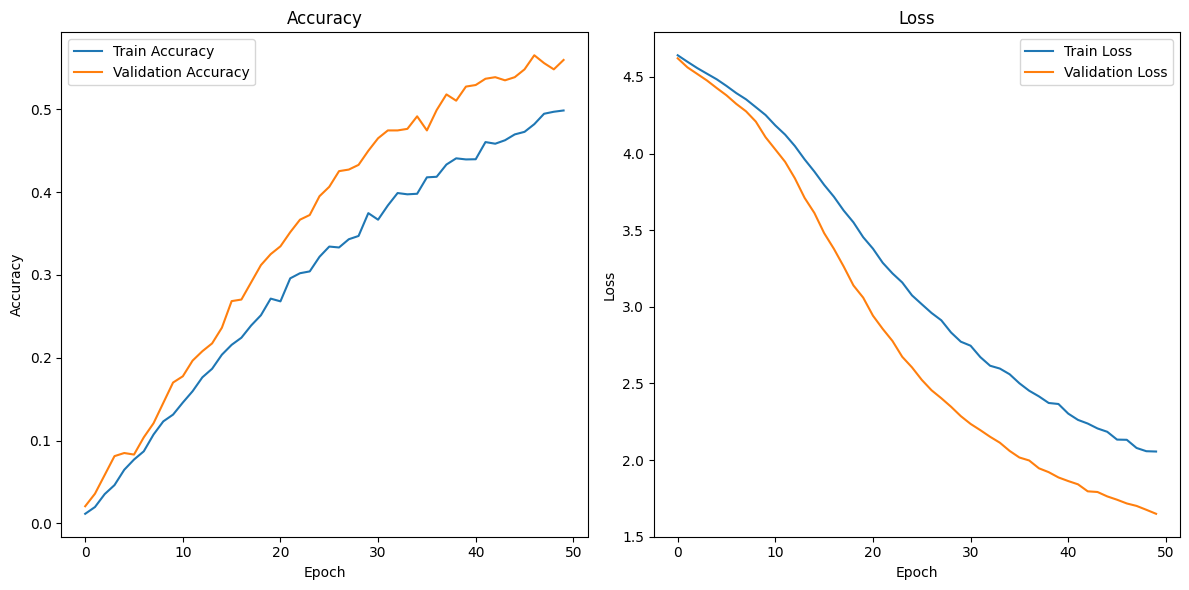

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()